## 5BL IK : Task Space (xy) to Joint Space (q1, q2)


In [273]:
import math

class FiveBL_Kinema :
    ## Data and performing kinematic calculations for a 5-bar linkage manipulator
    def __init__(self):
        self.d = 0.0 # cm
        self.l1 = 15.0 # cm
        self.l2 = 15.0 # cm
        self.l3 = 15.0 # cm
        self.l4 = 15.0 # cm

        '''
        Links:
        ground -> A (q1) -> l1 -> C -> l3 -> E (x, y)
        ground -> B (q2) -> l2 -> D -> l4 -> E (x, y)
        A -- l0 (d) -- B
        '''

    def inversePosition(self, x, y) -> tuple[float, float]:
        ''' Inverse kinematics for 5-bar linkage, returns (q1, q2) in radians '''
        # Calculate theta1 and theta2 based on (x, y)
        d = self.d
        l1 = self.l1
        l2 = self.l2
        l3 = self.l3
        l4 = self.l4

        ## Left side links
        r_A = math.sqrt(x**2 + y**2)
        alpha_A = math.atan2(y, x)
        cos_beta_A = (r_A**2 + l1**2 - l3**2) / (2 * r_A * l1)
        beta_A = math.acos(cos_beta_A)
        q1 = alpha_A + beta_A

        ## Right side links
        r_B = math.sqrt((x-d)**2 + y**2)
        alpha_B = math.atan2(y, x - d)
        cos_beta_B = (r_B**2 + l2**2 - l4**2) / (2 * r_B * l2)
        beta_B = math.acos(cos_beta_B)
        q2 = alpha_B - beta_B

        return (q1, q2)
    
    ## Helper function for Forward Kinematics
    def find_circle_intersection(self, x1, y1, x2, y2, r1, r2)-> tuple[float, float] : # where r1 = r2

        dx = x2 - x1
        dy = y2 - y1
        d = math.sqrt(dx**2 + dy**2)

        theta_1 = math.atan2(dy, dx)
        ang_C1 = math.acos((r1**2 + d**2 - r2**2)/ (2*r1*d))

        theta_r1 = theta_1 + ang_C1

        x_P1 = x1 + r1*math.cos(theta_r1)
        y_P1 = y1 + r1*math.sin(theta_r1)

        return (x_P1, y_P1)

    def forwardPosition(self, q1, q2) -> tuple[float, float]:
        ''' Forward kinematics for 5-bar linkage, returns (x, y) '''
        d = self.d
        l1 = self.l1
        l2 = self.l2
        l3 = self.l3
        l4 = self.l4

        # Position of point C
        x_C = l1 * math.cos(q1)
        y_C = l1 * math.sin(q1)

        # Position of point D
        x_D = d + l2 * math.cos(q2)
        y_D = l2 * math.sin(q2)

        # Find intersection of circles centered at C and D
        (x_E, y_E) = self.find_circle_intersection(x_C, y_C, x_D, y_D, l3, l4)

        return (x_E, y_E)

# instantiate
fiveBL_Kinema = FiveBL_Kinema()



### Test the 5BL Class
Perform IK and FK back to xy taskspace, to see if all points match the same

Forward Kinematics: x = -13.50 cm, y = 18.55 cm
Inverse Kinematics: q1 = 2.90 rad, q2 = 1.50 rad
Test points: [(-14.0, 4.0), (-14.0, 4.6), (-14.0, 5.2), (-14.0, 5.8), (-14.0, 6.4)] ...
Recalculated points: [(-14.000000000000004, 4.000000000000005), (-14.000000000000004, 4.599999999999998), (-14.000000000000004, 5.200000000000001), (-14.000000000000009, 5.800000000000001), (-14.000000000000005, 6.400000000000006)] ...


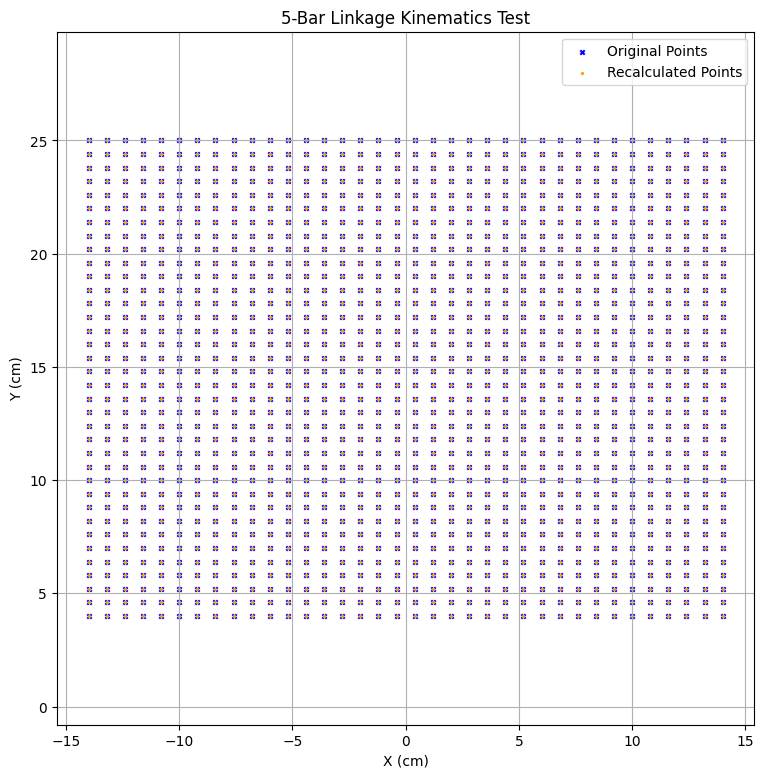

In [274]:
# isntantiate the kinematics class
#fiveBL_Kinema = FiveBL_Kinema()

x, y = fiveBL_Kinema.forwardPosition(2.9, 1.5)
print(f"Forward Kinematics: x = {x:.2f} cm, y = {y:.2f} cm")
q1, q2 = fiveBL_Kinema.inversePosition(x, y)
print(f"Inverse Kinematics: q1 = {q1:.2f} rad, q2 = {q2:.2f} rad")

import numpy as np
## Test the class
# Create a list of (x, y) points within the reachable workspace
x_points = np.linspace(-14, 14, 36)
y_points = np.linspace(4, 25, 36)
test_points = [(float(x), float(y)) for x in x_points for y in y_points]
test_qs = [fiveBL_Kinema.inversePosition(x, y) for (x, y) in test_points]
recalced_points = [fiveBL_Kinema.forwardPosition(q1, q2) for (q1, q2) in test_qs]

# print the results
print(f"Test points: {test_points[:5]} ...")
print(f"Recalculated points: {recalced_points[:5]} ...")

# plot the results as scatter plot in xy space
import matplotlib.pyplot as plt
x_test, y_test = zip(*test_points)
x_recalc, y_recalc = zip(*recalced_points)
plt.figure(figsize=(9, 9))
plt.scatter(x_test, y_test, color='blue', marker='x', s=10, label='Original Points')
plt.scatter(x_recalc, y_recalc, color='orange', s=2, label='Recalculated Points')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('5-Bar Linkage Kinematics Test')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()


## Joint Space to Cam Profile

In [275]:
def rotatePoint(theta, x, y) -> tuple[float, float]:
    ''' Rotate point (x, y) by angle theta (radians) around origin '''
    x_rot = x * math.cos(theta) - y * math.sin(theta)
    y_rot = x * math.sin(theta) + y * math.cos(theta)
    return (x_rot, y_rot)

In [276]:
class Cam_Kinema :
    ## Data and calculations for a cam-follower mechanism
    def __init__(self):
        self.l_follower = 10.0 # cm
        self.ang_offset_deg = 20.0 # deg
        self.ang_offset = math.radians(self.ang_offset_deg) # rad
        self.a = 10.5 # cm // distance from base to cam center

        '''
        phi : angle of cam
        psi : angle displacement of follower
        '''

    ## link 1 and follower 1
    def invertFollower1(self, psi, phi_cam=0) -> tuple[float, float]:
        '''Find xy of follower tip, given the displacement psi (rad) and cam angle phi_cam (rad)'''
        l_follower = self.l_follower
        a = self.a

        # Position of follower tip before rotation
        follower_x = l_follower * math.sin(psi)
        follower_y = a - l_follower * math.cos(psi)

        # Rotate by cam angle phi_cam
        (r_x, r_y) = rotatePoint(phi_cam, follower_x, follower_y)
        
        return (r_x, r_y)
    
    def get_r1_from_q1(self, q1, phi_cam=0) -> tuple[float, float]:
        ''' Get follower tip position from cam angle q1 '''
        psi1 = q1 - math.pi/2 - self.ang_offset
        return self.invertFollower1(psi1, phi_cam)

    ## link 2 and follower 2
    def invertFollower2(self, psi, phi_cam=0) -> tuple[float, float]:
        '''Find xy of follower tip, given the displacement psi (rad) and cam angle phi_cam (rad)'''
        l_follower = self.l_follower
        a = self.a

        # Position of follower tip before rotation
        follower_x = - l_follower * math.sin(psi)
        follower_y = a - l_follower * math.cos(psi)

        # Rotate by cam angle phi_cam
        (r_x, r_y) = rotatePoint(phi_cam, follower_x, follower_y)
        
        return (r_x, r_y)

    def get_r2_from_q2(self, q2, phi_cam=0) -> tuple[float, float]:
        ''' Get follower tip position from cam angle q2 '''
        psi2 = math.pi/2 - q2 - self.ang_offset
        return self.invertFollower2(psi2, phi_cam)

# isntantiate
cam_Kinema = Cam_Kinema()



### Test the Cam Class

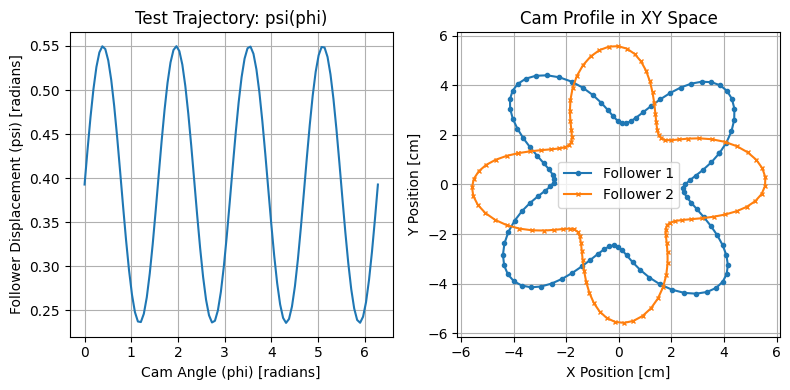

Cam profile points for Follower 1 (x, y):
[[ 3.82683432e+00  1.26120467e+00]
 [ 4.08978360e+00  1.68210008e+00]
 [ 4.28417627e+00  2.13967067e+00]
 [ 4.38976442e+00  2.60732236e+00]
 [ 4.39602265e+00  3.05460528e+00]
 [ 4.30225299e+00  3.45157945e+00]
 [ 4.11613376e+00  3.77272968e+00]
 [ 3.85133222e+00  3.99980601e+00]
 [ 3.52491161e+00  4.12334055e+00]
 [ 3.15512397e+00  4.14291898e+00]
 [ 2.75989430e+00  4.06647775e+00]
 [ 2.35599291e+00  3.90895469e+00]
 [ 1.95866426e+00  3.69058968e+00]
 [ 1.58138191e+00  3.43510681e+00]
 [ 1.23543551e+00  3.16793831e+00]
 [ 9.29193058e-01  2.91457581e+00]
 [ 6.67069250e-01  2.69905462e+00]
 [ 4.48414028e-01  2.54250520e+00]
 [ 2.66669689e-01  2.46167543e+00]
 [ 1.09198040e-01  2.46737424e+00]
 [-4.18722095e-02  2.56292403e+00]
 [-2.07598090e-01  2.74290040e+00]
 [-4.09078889e-01  2.99259797e+00]
 [-6.63667637e-01  3.28868350e+00]
 [-9.81295446e-01  3.60130851e+00]
 [-1.36179789e+00  3.89756973e+00]
 [-1.79398710e+00  4.14575435e+00]
 [-2.25679564

In [277]:
cam = Cam_Kinema()

# Generate test data for psi(phi) as a sine function
phi_vals = np.linspace(0, 2 * np.pi, 100)  # Cam angle from 0 to 2pi
psi_vals = [math.pi/20 * math.sin(4 * phi) + math.pi/4 / 2 for phi in phi_vals]  # psi as sine function of phi
psi_vals = np.array(psi_vals)

# Store the (x, y) points for the cam profile
f1_points = []
f2_points = []

# Compute follower positions (x, y) for both followers
for i in range(len(phi_vals)):
    f1_x, f1_y = cam.invertFollower1(psi_vals[i], phi_vals[i])
    f2_x, f2_y = cam.invertFollower2(psi_vals[i], phi_vals[i])

    f1_points.append((f1_x, f1_y))
    f2_points.append((f2_x, f2_y))

# Convert to numpy arrays for easy plotting
f1_points = np.array(f1_points)
f2_points = np.array(f2_points)

# Plot the trajectory of psi(phi)
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(phi_vals, psi_vals, label="psi(phi) = sin(phi)")
plt.xlabel('Cam Angle (phi) [radians]')
plt.ylabel('Follower Displacement (psi) [radians]')
plt.title('Test Trajectory: psi(phi)')
plt.grid(True)

# Plot the cam profile (x, y) points
plt.subplot(1, 2, 2)
plt.plot(f1_points[:, 0], f1_points[:, 1], label="Follower 1", marker='o', markersize=3)
plt.plot(f2_points[:, 0], f2_points[:, 1], label="Follower 2", marker='x', markersize=3)
plt.xlabel('X Position [cm]')
plt.ylabel('Y Position [cm]')
plt.title('Cam Profile in XY Space')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print("Cam profile points for Follower 1 (x, y):")
print(f1_points)


## Integrate 5BL to Cam Follower
From task space P(phi) = (x, y) to follower profile r1(phi) = (r1_x, r1_y), r2(phi) = (r2_x, r2_y)

### Task Trajecory Planning

In [278]:
from dataclasses import dataclass


In [279]:
@dataclass(slots=True)
class Point :
    ''' Cartesian point '''
    x: float = 0.0
    y: float = 0.0

class TaskTrajectory :
    ''' Trajectory in task space defined by path data points:  P(phi) = (x, y) '''
    def __init__(self, pathPoints: list[Point] = []):
        self.pathPoints: list[Point] = pathPoints  # List of (x, y) tuples representing the path
        self.pathLenght = 0.0
        self.dp_per_dphi = 0.0 # dp by dphi : pathLength per phi cam angle # cm/rad
        self.dphi_per_dt = 1.0 # rad/s : speed of cam rotation
        self.phi_end = 2 * math.pi  # rad : end angle of cam rotation when path ends

        self.setPathPoints(pathPoints)


    def setPathPoints(self, pathPoints: list[Point]) -> None:
        ''' Set the path points and compute path length '''
        self.pathPoints = pathPoints
        self.pathLenght = self.computePathLength(pathPoints)
        print(f"Set path with {len(pathPoints)} points, total length = {self.pathLenght:.2f} cm")
        self.dp_per_dphi = self.pathLenght / self.phi_end  # assuming full rotation for now
        print(f"Computed dp/dphi = {self.dp_per_dphi:.4f} cm/rad")
        print(f"Computed dp/dphi = {self.dp_per_dphi * (math.pi / 180):.4f} cm/deg")
        

    def computePathLength(self, pathPoints: list[Point]) -> float:
        ''' Compute the total length of the path defined by pathPoints '''
        length = 0.0
        for i in range(1, len(pathPoints)):
            p1 = pathPoints[i - 1]
            p2 = pathPoints[i]
            segment_length = math.sqrt((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2)
            length += segment_length
        return length

    def get_p_at_phi(self, phi_cam: float) -> Point:
        ''' Get the p(phi_cam) = (x, y) point on the path corresponding to cam angle phi_cam '''
        # Calculate the distance along the path for the given phi_cam
        distance_along_path = self.dp_per_dphi * phi_cam

        # Find the segment of the path that contains this distance
        accumulated_length = 0.0
        for i in range(1, len(self.pathPoints)):
            p1 = self.pathPoints[i - 1]
            p2 = self.pathPoints[i]
            segment_length = math.sqrt((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2)

            if accumulated_length + segment_length >= distance_along_path:
                # The point lies on this segment
                remaining_length = distance_along_path - accumulated_length
                ratio = remaining_length / segment_length
                x = p1.x + ratio * (p2.x - p1.x)
                y = p1.y + ratio * (p2.y - p1.y)
                return Point(x, y)

            accumulated_length += segment_length

        # If phi_cam exceeds the path length, return the last point
        return self.pathPoints[-1]

taskTrajectory = TaskTrajectory()




Set path with 0 points, total length = 0.00 cm
Computed dp/dphi = 0.0000 cm/rad
Computed dp/dphi = 0.0000 cm/deg


### Automaton: Task Trajectory to Cam Profile

In [280]:
@dataclass(slots=True)
class CamProfileData :
    ''' Data structure of each point in cam profile '''
    phi_cam: float = 0
    x: float = 0
    y: float = 0

In [281]:
from tqdm import tqdm

class Automaton :
    ''' Integrate 5BL and Cam Follower kinematics '''
    ''' Frame data and perform calculations '''
    def __init__(self):
        # workspace origin offset
        self.ws_x = 0.0 # cm
        self.ws_y = 18.0 # cm

        #self.IK_taskPoint_to_camProfile = IK_taskPoint_to_camProfile

    def IK_taskPoint_to_camProfile(self, x, y, phi_cam) -> tuple[CamProfileData, CamProfileData]:
        ''' from p(phi) = (x, y) to r1(phi) = (r1_x, r1_y), r2(phi) = (r2_x, r2_y) '''
        # Get joint angles from task point
        try:
            (q1, q2) = fiveBL_Kinema.inversePosition(x, y)
        except ValueError as e:
            print(f"Error in inverse kinematics: {e}")
            return (None, None)
        
        # Get follower tip positions from joint angles
        (r1_x, r1_y) = cam_Kinema.get_r1_from_q1(q1, phi_cam)
        (r2_x, r2_y) = cam_Kinema.get_r2_from_q2(q2, phi_cam)
        r1_data = CamProfileData(phi_cam, r1_x, r1_y)
        r2_data = CamProfileData(phi_cam, r2_x, r2_y)

        return (r1_data, r2_data)

    def generateCamProfile(self, taskTrajectory: TaskTrajectory, num_points: int = 501) -> tuple[list[CamProfileData], list[CamProfileData]]:
        ''' Generate cam profile data from task trajectory '''
        cam_profile1: list[CamProfileData] = []
        cam_profile2: list[CamProfileData] = []

        for i in tqdm(range(num_points), desc="Generating Cam Profile"):
            phi_cam = taskTrajectory.phi_end * i / (num_points - 1)  # from 0 to 2pi
            task_point = taskTrajectory.get_p_at_phi(phi_cam)
            p_x = task_point.x + self.ws_x
            p_y = task_point.y + self.ws_y

            (r1_data, r2_data) = self.IK_taskPoint_to_camProfile(p_x, p_y, phi_cam)
            if r1_data is not None and r2_data is not None:
                cam_profile1.append(r1_data)
                cam_profile2.append(r2_data)

        return (cam_profile1, cam_profile2)
    
automaton = Automaton()

In [282]:
# Example usage
r1, r2 = automaton.IK_taskPoint_to_camProfile(10.0, 10.0, math.pi/4)
print(f"Follower 1 Position: phi={r1.phi_cam:.2f}, x={r1.x:.2f}, y={r1.y:.2f}")
print(f"Follower 2 Position: phi={r2.phi_cam:.2f}, x={r2.x:.2f}, y={r2.y:.2f}")

Follower 1 Position: phi=0.79, x=-0.75, y=-0.02
Follower 2 Position: phi=0.79, x=-14.10, y=-0.02


#### Perform Test Task

Set path with 5 points, total length = 20.00 cm
Computed dp/dphi = 3.1831 cm/rad
Computed dp/dphi = 0.0556 cm/deg


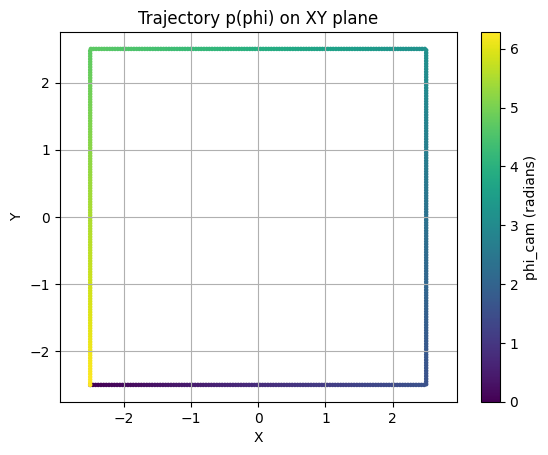

In [283]:
# test path data: square 5*5
pathData = [Point(-2.5, -2.5),
            Point(2.5, -2.5),
            Point(2.5, 2.5),
            Point(-2.5, 2.5),
            Point(-2.5, -2.5)]

#taskTrajectory = TaskTrajectory(pathPoints=pathData)
taskTrajectory.setPathPoints(pathData)

# plot trajectory p(phi) = (x, y) on xy plane
# the color parametrized by phi_cam angle from 0 to 2pi
import matplotlib.pyplot as plt
phi_vals = np.linspace(0, 2 * math.pi, 500)
p_points = [taskTrajectory.get_p_at_phi(phi) for phi in phi_vals]
p_x = [p.x for p in p_points]
p_y = [p.y for p in p_points]

plt.scatter(p_x, p_y, c=phi_vals, cmap='viridis', s=5) # viridis, cividis, inferno,, hsv
plt.colorbar(label='phi_cam (radians)')
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory p(phi) on XY plane')
plt.axis('equal')
plt.show()


Generating Cam Profile: 100%|██████████| 2001/2001 [00:00<00:00, 179917.73it/s]


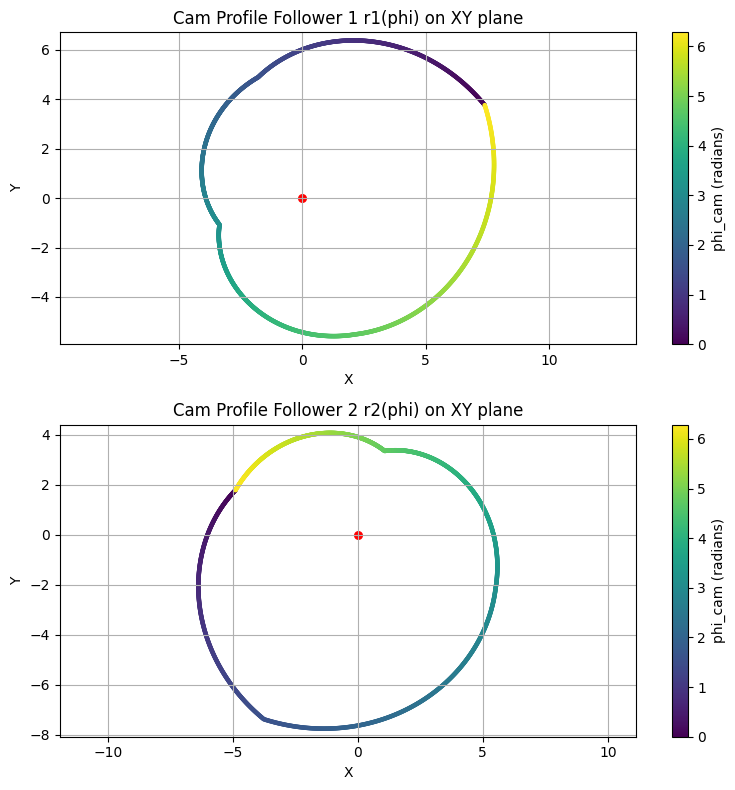

In [284]:

## generate cam profile ------------------------------------------
(cam_profile1, cam_profile2) = automaton.generateCamProfile(taskTrajectory, num_points=2001)
# plot the 2 cam profiles on xy plane
# the color parametrized by phi_cam angle from 0 to taskTrajectory.phi_end
phi_vals1 = [data.phi_cam for data in cam_profile1]
x1_vals = [data.x for data in cam_profile1]
y1_vals = [data.y for data in cam_profile1]
phi_vals2 = [data.phi_cam for data in cam_profile2]
x2_vals = [data.x for data in cam_profile2]
y2_vals = [data.y for data in cam_profile2]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.scatter(x1_vals, y1_vals, c=phi_vals1, cmap='viridis', s=5)
plt.colorbar(label='phi_cam (radians)')
plt.scatter([0], [0], c='red', marker='o', s=30) # cam center
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Cam Profile Follower 1 r1(phi) on XY plane')
plt.axis('equal')

plt.subplot(2, 1, 2)
plt.scatter(x2_vals, y2_vals, c=phi_vals2, cmap='viridis', s=5)
plt.colorbar(label='phi_cam (radians)')
plt.scatter([0], [0], c='red', marker='o', s=30) # cam center
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Cam Profile Follower 2 r2(phi) on XY plane')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Export Cam Profile Geometry

In [285]:
# Export cam profile to svg file
def exportCamProfileToSVG(filename: str, cam_profile: list[CamProfileData], center_x: float = 0.0, center_y: float = 0.0) -> None:
    ''' Export cam profile points to SVG file '''
    with open(filename, 'w') as f:
        f.write('<?xml version="1.0" standalone="no"?>\n')
        f.write('<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\n')
        f.write('  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n')
        f.write(f'<svg width="200mm" height="200mm" viewBox="-100 -100 200 200" xmlns="http://www.w3.org/2000/svg" version="1.1">\n')
        
        f.write('<g stroke="orange" stroke-width="0.5" fill="none">\n')

        # Write path data
        f.write('<path d="M ')
        for i, point in enumerate(cam_profile):
            x_svg = (point.x + center_x) * 10  # scale to mm
            y_svg = -(point.y + center_y) * 10  # scale to mm
            if i == 0:
                f.write(f'{x_svg:.5f},{y_svg:.5f} ')
            else:
                f.write(f'L {x_svg:.5f},{y_svg:.5f} ')
        f.write('"/>\n')

        # Write cam center
        f.write(f'<circle cx="{center_x * 10:.5f}" cy="{center_y * 10:.5f}" r="1" fill="red"/>\n')

        # write 2 short lines as xy axes for reference, at the cam canter
        axis_length = 1  # cm
        f.write(f'<line x1="{(center_x) * 10:.5f}" y1="{center_y * 10:.5f}" x2="{(center_x + axis_length) * 10:.5f}" y2="{center_y * 10:.5f}" stroke="blue" stroke-width="0.5"/>\n')
        f.write(f'<line x1="{center_x * 10:.5f}" y1="{(center_y) * 10:.5f}" x2="{center_x * 10:.5f}" y2="{(center_y - axis_length) * 10:.5f}" stroke="blue" stroke-width="0.5"/>\n')

        f.write('</g>\n')
        f.write('</svg>\n')

exportCamProfileToSVG('cam_profile1.svg', cam_profile1)
exportCamProfileToSVG('cam_profile2.svg', cam_profile2)

In [286]:
# print file contents
with open('cam_profile1.svg', 'r') as f:
    content = f.read()
    print(content)
with open('cam_profile2.svg', 'r') as f:
    content = f.read()
    print(content)



<?xml version="1.0" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg width="200mm" height="200mm" viewBox="-100 -100 200 200" xmlns="http://www.w3.org/2000/svg" version="1.1">
<g stroke="orange" stroke-width="0.5" fill="none">
<path d="M 73.85203,-37.57688 L 73.69553,-37.76674 L 73.53851,-37.95599 L 73.38098,-38.14462 L 73.22295,-38.33263 L 73.06441,-38.52001 L 72.90536,-38.70677 L 72.74582,-38.89291 L 72.58578,-39.07842 L 72.42524,-39.26330 L 72.26421,-39.44755 L 72.10268,-39.63118 L 71.94067,-39.81417 L 71.77817,-39.99652 L 71.61519,-40.17825 L 71.45173,-40.35933 L 71.28778,-40.53978 L 71.12336,-40.71959 L 70.95847,-40.89876 L 70.79310,-41.07729 L 70.62727,-41.25518 L 70.46096,-41.43243 L 70.29419,-41.60903 L 70.12696,-41.78498 L 69.95927,-41.96029 L 69.79112,-42.13494 L 69.62252,-42.30895 L 69.45347,-42.48231 L 69.28396,-42.65502 L 69.11401,-42.82707 L 68.94361,-42.99847 L 68.77276,-43.16921 L 68.60148,-43.33